A Random Forest regression model will be trained to predict epigenetic age using DNA methylation beta values. 

In [3]:
# Load required packages
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

In [4]:
# Load data set
GSE55763_beta = pd.read_csv("subset_500_Beta.csv")

In [5]:
#Display the first rows of the data set
GSE55763_beta.head(3)

,X,gender,age,cg00116092,cg01974375,cg01557798,cg00145253,cg01747664,cg01352586,cg02177231,...,cg02491234,cg00774867,cg02902318,cg01763916,cg01537494,cg02099814,cg02182827,cg02026604,cg02922094,cg02087985
0,GSM1343050,M,57.9,0.212820,0.229511,0.363436,0.371299,0.196389,0.170968,0.215720,...,0.777571,0.723192,0.725641,0.522854,0.822839,0.216522,0.661946,0.134098,0.737352,0.702622
1,GSM1343051,M,42.0,0.206923,0.234765,0.361194,0.329642,0.229280,0.145736,0.176131,...,0.747724,0.731679,0.755315,0.517066,0.802776,0.161018,0.693207,0.129818,0.753899,0.596400
2,GSM1343052,M,47.4,0.181512,0.276554,0.304722,0.306550,0.179404,0.123335,0.194134,...,0.734433,0.779513,0.719639,0.485681,0.830565,0.140208,0.709848,0.128152,0.776271,0.673926


In [6]:
print(GSE55763_beta.shape) #dimensions of the data set

(2664, 503)


The data set contains 2664 rows and 503 columns 

In [8]:
# Select CpG columns
cpg_cols = [col for col in GSE55763_beta.columns if col.startswith("cg")]

# Define predictors and outcome
X = GSE55763_beta[cpg_cols + ["gender"]].copy()
y = GSE55763_beta["age"]

# Encode gender numerically
X["gender"] = X["gender"].map({"M": 1, "F": 0})

In [9]:
# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=500
)

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Train Random Forest model

In [11]:
rf = RandomForestRegressor(n_estimators=300, random_state=500)
rf.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
#Cross-Validation 
kf = KFold(n_splits=5, shuffle=True, random_state=500)
rf_cv = RandomForestRegressor(n_estimators=300, random_state=500)

scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

cv_results = cross_validate(
    rf_cv,
    X_train_scaled,
    y_train,
    cv=kf,
    scoring=scoring,
    return_train_score=False
)

print("Random Forest 5-Fold Cross-Validation Results:")
print(f"Mean R²:   {np.mean(cv_results['test_R2']):.2f}")
print(f"Mean MAE:  {abs(np.mean(cv_results['test_MAE'])):.2f}")
print(f"Mean RMSE: {abs(np.mean(cv_results['test_RMSE'])):.2f}")


Random Forest 5-Fold Cross-Validation Results:
Mean R²:   0.61
Mean MAE:  5.08
Mean RMSE: 6.31


Metrics (R2, MAE, RMSE)

In [14]:
# Predict on test set
y_pred = rf.predict(X_test_scaled)

# Metrics
r2 = rf.score(X_test_scaled, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.60
MAE: 5.03
RMSE: 6.19


InterpretationR² of 0.60 indicates that approximately 60% of the variance in chronological age is explained by the model. MAE of 5.03 years shows that, on average, the predicted age deviates from the actual age by about 5 years. RMSE of 6.19 years reflects the overall magnitude of prediction errors, giving slightly more weight to larger deviations.

In this part, SHAP values are computed to interpret the Random Forest model, showing how much each feature (CpG or covariate) contributes to increasing or decreasing the predicted age for each sample.

Summary plot for the test set: tvisualizes the impact of each CpG on the model’s predictions

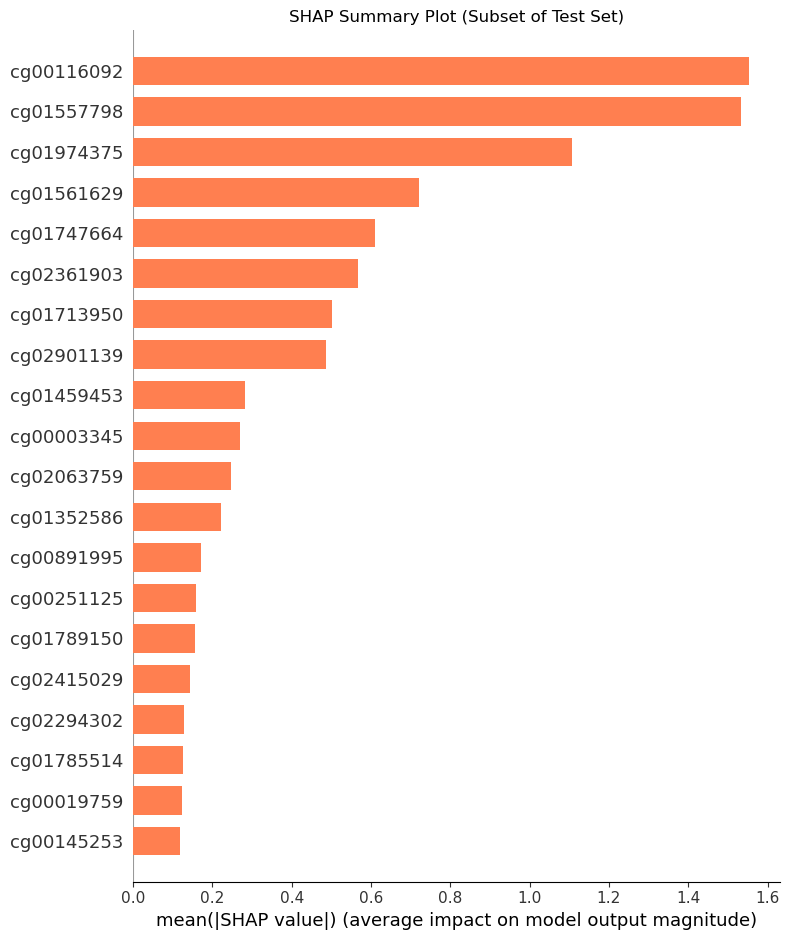

In [18]:
# Compute SHAP values on a subset of the test set
explainer = shap.TreeExplainer(rf)
X_shap = X_test_scaled.sample(100, random_state=500)
shap_values = explainer.shap_values(X_shap)

# SHAP summary bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", color="coral", show=False)
plt.title("SHAP Summary Plot (Subset of Test Set)")
plt.tight_layout()
plt.savefig("shap_summary_test_subset.png", dpi=300)
plt.show()

Summary plot (bar plot): shows the average contribution of each CpG to the Random Forest predictions, ranking them by importance using SHAP values.

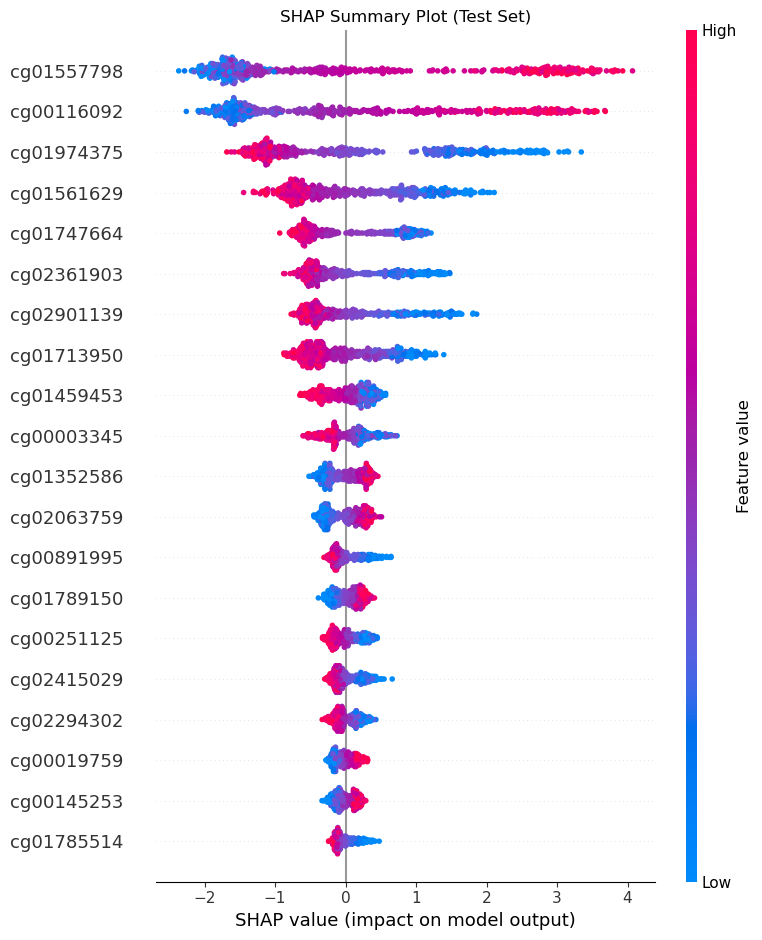

In [20]:
# Compute SHAP values on the full test set
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

# SHAP beeswarm summary plot (default style)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.title("SHAP Summary Plot (Test Set)")
plt.tight_layout()
plt.savefig("shap_summary_test.png", dpi=300)
plt.show()


In [21]:
if isinstance(shap_values, list):  
    shap_vals = shap_values[1]
else: 
    shap_vals = shap_values

mean_shap = np.abs(shap_vals).mean(axis=0)

# Create data frame
shap_df = pd.DataFrame({
    "CpG": X_test_scaled.columns,
    "Mean_SHAP": mean_shap
})

# Order descending order
shap_df = shap_df.sort_values(by="Mean_SHAP", ascending=False)

# Save CSV file
shap_df.to_csv("CpG_SHAP_importance.csv", index=False)

Extract predictions

In [23]:
y_pred = rf.predict(X_test_scaled)

In [24]:
y_pred_full = rf.predict(pd.DataFrame(scaler.transform(X), columns=X.columns))


In [25]:
# --- Obtain predictions for the entire dataset (all 2664 samples) ---
y_pred_full = rf.predict(pd.DataFrame(scaler.transform(X), columns=X.columns))

# --- Create DataFrame with observed and predicted ages for all samples ---
results_rf_full = pd.DataFrame({
    "SampleID": GSE55763_beta["X"],       # Sample ID
    "Observed_Age": GSE55763_beta["age"], # Actual chronological age
    "Pred_RF": y_pred_full                # Predicted epigenetic age (Random Forest)
})

# --- Save the results to a CSV file ---
results_rf_full.to_csv("RF_Predicted_Ages_full.csv", index=False)

print("Full dataset predictions saved successfully!")
print(results_rf_full.shape)

Full dataset predictions saved successfully!
(2664, 3)


In [26]:
# Save the results in a csv file
results_rf_full.to_csv("RF_Predicted_Ages.csv", index=False)